Removed empty summaries by hand

In [1]:
import sys
import os
import time
import json
import numpy as np
import scipy as sp
import pandas as pd
from scipy.stats import  kendalltau
from scipy.spatial import ConvexHull
from scipy.spatial.qhull import QhullError
from scipy.spatial.distance import cdist, pdist
from operator import itemgetter
from itertools import chain
from collections import Counter
from ipywidgets import interact
from plotly.offline import init_notebook_mode, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from gensim.parsing.preprocessing import preprocess_documents

import matplotlib.pyplot as plt

import torch
from torch.utils.tensorboard import SummaryWriter

from config import *

from typing import Callable

## Extractive Summarization by Maximizing Semantic Volume

Paper: https://www.aclweb.org/anthology/D15-1228.pdf

In [2]:
def max_semantic_volume_summary(R: np.array, L: int, dist: Callable) -> list:
    '''Implementation of the "Extractive Summarization by Maximizing Semantic Volume".
    
    :param R:    Sentence reprezentations
    :param L:    Number of sentences in summary
    :param dist: Function that computes distance to subspace
    
    :return: Sentence indices
    '''
    def mask(N, idx):
        mask = np.ones(N, dtype=bool)
        mask[idx] = False
        return mask

    N = R.shape[0]

    B = np.ndarray(shape=(0,R.shape[1]))
    idx = []

    c = R.sum(axis=0) / N

    p = np.argmax(np.linalg.norm(R - c, axis=1))
    idx.append(p)

    q = np.argmax(np.linalg.norm(R - R[p], axis=1))
    idx.append(q)

    b_0 = R[q] / np.linalg.norm(R[q])
    B = np.append(B, b_0.reshape(1,-1), axis=0)

    for i in range(L-2):
        r = np.argmax(np.apply_along_axis(dist, 1, R[mask(N, idx)], B))
        if r not in idx:
            idx.append(r)

            b_r = R[r] / np.linalg.norm(R[r])
            B = np.append(B, b_r.reshape(1,-1), axis=0)
        
    return idx

### Misc

In [3]:
def load_data(dataset, encoded):
    ext = '_encoded.json' if encoded else '.json'
    with open(os.path.join(DATA_DIR, dataset + ext), mode='r') as fp:
        return json.load(fp)
    
def extract(topic):
    documents = np.array(list(chain(*topic['documents'])))
    annotations = topic['annotations']

    summaries_tmp = list(map(itemgetter('text'), annotations))
    indices_tmp = np.cumsum([0] + list(map(len, summaries_tmp)))
    summaries = np.array(list(chain(*summaries_tmp)))
    indices = np.array(list(zip(indices_tmp[:-1], indices_tmp[1:])))
    
    pyr_scores = np.array(list(map(itemgetter('pyr_score'), annotations)))
    
    return documents, summaries, indices, pyr_scores

### Visualization

In [4]:
def make_pytorch_projector(log_dir, mat, labels=None):
    '''Exports PyTorch projector'''
    writer = SummaryWriter(log_dir)
    writer.add_embedding(mat, metadata=labels)
    writer.close()

def project_pca(document_embs, summary_embs):
    pca = PCA(n_components=2)
    document_pts = pca.fit_transform(document_embs)
    summary_pts = pca.transform(summary_embs)
    return document_pts, summary_pts

def project_tsne(document_embs, summary_embs, n_iter=3000, perplexity=30):
    tsne = TSNE(n_iter=n_iter, perplexity=perplexity, verbose=1)
    pts = tsne.fit_transform(np.concatenate((document_embs, summary_embs)))
    t = document_embs.shape[0]
    return pts[:t], pts[t:]

def plt_hull(ax, pts, c):
    hull = ConvexHull(pts)
    idx = np.concatenate((hull.vertices, hull.vertices[:1]))
    ax.plot(pts[idx,0], pts[idx,1], c=c, linestyle='dashed', lw=2)
    
def plot(proj, ax, document_pts, summary_pts, plot_hull=True):
    ax.scatter(document_pts[:,0], document_pts[:,1], c='tab:blue', alpha=(0.15 if plot_hull else 1))
    ax.scatter(summary_pts[:,0], summary_pts[:,1], c='tab:red', alpha=(0.5 if plot_hull else 1))
    if plot_hull:
        plt_hull(ax, document_pts, 'tab:blue')
        plt_hull(ax, summary_pts, 'tab:red')
    ax.set_xlabel(f'{proj}-0')
    ax.set_ylabel(f'{proj}-1')

### Metrics

In [5]:
def repeating_words(summary):
    '''Counts the number of repeating words in a summary'''
    cnt = Counter(chain(*preprocess_documents(summary)))
    return len([cnt[k] for k in cnt if cnt[k] > 1])

def distance_to_subspace(v: np.array, S: np.array) -> int:
    '''Calculates a distance from vector to subspace'''
    return np.linalg.norm(v - (v @ S.T) @ S)

def average_distance(S: np.array) -> int:
    '''Calculates the average distance between vectors'''
    return np.mean(cdist(S, S))

def semantic_volume(S: np.array, normalize: bool=False, D: np.array=None) -> int:
    '''Calculates the semantic volume'''
    try:
        S_hull = ConvexHull(S)
        if not normalize:
            return S_hull.volume
        D_hull = ConvexHull(D)
        return S_hull.volume / D_hull.volume
    except QhullError as e:
        return 0

def calculate_scores(indices, metric):
    return np.array([metric(i) for i in indices])

# Introduction

Use-case:
1. Take the documents, summaries, and pyramid scores
2. Embed the documents and summaries (or load embeddings)
3. Calculate score for summaries
4. Compute correlation with human judgements
5. Plot

In [6]:
DATASET = DATASETS[0]
TOPIC = 'D0805'

# Scores

In [7]:
def execute_experiment(tac, experiment):
    scores = []

    for topic_id, topic in tac.items():
        document_embs, summary_embs, indices, pyr_scores = extract(topic)
        scores.append(experiment(document_embs, summary_embs, indices, pyr_scores))
    
    return scores

In [8]:
def experiment_repeating_words(documents, summaries, indices, pyr_scores):
    metric = lambda i: repeating_words(summaries[i[0]:i[1]])
    return kendalltau(pyr_scores, calculate_scores(indices, metric))[0]

def experiment_average_distance(document_embs, summary_embs, indices, pyr_scores):
    metric = lambda i: average_distance(summary_embs[i[0]:i[1]])
    return kendalltau(pyr_scores, calculate_scores(indices, metric))[0]

def experiment_semantic_volume(document_embs, summary_embs, indices, pyr_scores):
    document_pts, summary_pts = project_pca(document_embs, summary_embs)
    metric = lambda i: semantic_volume(summary_pts[i[0]:i[1]])
    return kendalltau(pyr_scores, calculate_scores(indices, metric))[0]

def experiment_semantic_volume_norm(document_embs, summary_embs, indices, pyr_scores):
    document_pts, summary_pts = project_pca(document_embs, summary_embs)
    metric = lambda i: semantic_volume(summary_pts[i[0]:i[1]], normalize=True, D=document_pts)
    return kendalltau(pyr_scores, calculate_scores(indices, metric))[0]

In [9]:
tac_ = load_data(DATASET, encoded=False)
tac = load_data(DATASET, encoded=True)

In [10]:
print('=== Experiments ===\n')
s = ''

print('   Executing "Repeating words"')
scores = execute_experiment(tac_, experiment_repeating_words)
s += f'   Repeating words:           {np.mean(scores):.6f}\n'

print('   Executing "Average distance"')
scores = execute_experiment(tac, experiment_average_distance)
s += f'   Average distance:          {np.mean(scores):.6f}\n'

print('   Executing "Semantic volume"')
scores = execute_experiment(tac, experiment_semantic_volume)
s += f'   Semantic volume:           {np.mean(scores):.6f}\n'

print('   Executing "Semantic volume (norm)"')
scores = execute_experiment(tac, experiment_semantic_volume_norm)
s += f'   Semantic volume (norm):    {np.mean(scores):.6f}\n'

print('\n=== Results ===\n')
print(s)

=== Experiments ===

   Executing "Repeating words"
   Executing "Average distance"
   Executing "Semantic volume"
   Executing "Semantic volume (norm)"

=== Results ===

   Repeating words:           0.114269
   Average distance:          -0.015680
   Semantic volume:           0.014678
   Semantic volume (norm):    0.014677



# Plotting BERT

In [11]:
### Load
tac = load_data(DATASET, encoded=True)

### Extract
topic = tac[TOPIC]
document_embs, summary_embs, indices, pyr_scores = extract(topic)

### Get indices of sorted pyramid socres
m = np.argsort(-pyr_scores) # Holds sorted indices of the pyramid scores

## System Summaries

### TensorBoard

In [12]:
t = int(time.time())

data = torch.tensor(np.concatenate((document_embs, summary_embs[indices[m[0],0]:indices[m[0],1]])))
labels = [0] * document_embs.shape[0] + [1] * summary_embs[indices[m[0],0]:indices[m[0],1]].shape[0]
make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_sumarization_{t}'), data, labels)

### PCA

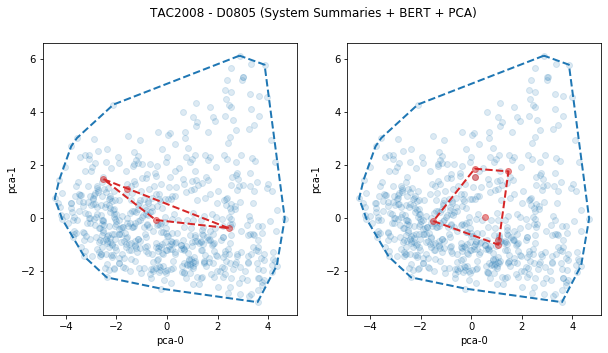

In [13]:
document_pts, summary_pts = project_pca(document_embs, summary_embs)

fig = plt.figure(figsize=(10,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (System Summaries + BERT + PCA)')
ax1 = fig.add_subplot(1,2,1)
plot('pca', ax1, document_pts, summary_pts[indices[m[0],0]:indices[m[0],1]], plot_hull=True)
ax2 = fig.add_subplot(1,2,2)
plot('pca', ax2, document_pts, summary_pts[indices[m[1],0]:indices[m[1],1]], plot_hull=True)
plt.show()

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 897 samples in 0.026s...
[t-SNE] Computed neighbors for 897 samples in 1.048s...
[t-SNE] Computed conditional probabilities for sample 897 / 897
[t-SNE] Mean sigma: 2.429632
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.709274
[t-SNE] KL divergence after 3000 iterations: 1.212315


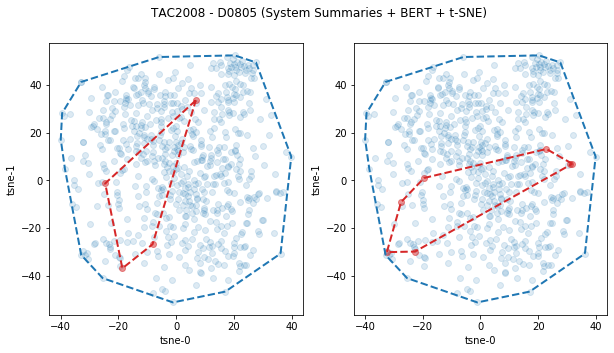

In [14]:
document_pts, summary_pts = project_tsne(document_embs, summary_embs)

fig = plt.figure(figsize=(10,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (System Summaries + BERT + t-SNE)')
ax1 = fig.add_subplot(1,2,1)
plot('tsne', ax1, document_pts, summary_pts[indices[m[0],0]:indices[m[0],1]], plot_hull=True)
ax2 = fig.add_subplot(1,2,2)
plot('tsne', ax2, document_pts, summary_pts[indices[m[1],0]:indices[m[1],1]], plot_hull=True)
plt.show()

## Extractive Summarization by Maximizing Semantic Volume

### PCA

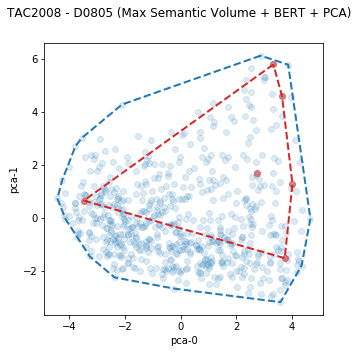

In [15]:
idx = max_semantic_volume_summary(document_embs, 6, distance_to_subspace)

document_pts, summary_pts = project_pca(document_embs, document_embs[idx])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + BERT + PCA)')
ax1 = fig.add_subplot(1,1,1)
plot('pca', ax1, document_pts, summary_pts, plot_hull=True)

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 627 samples in 0.019s...
[t-SNE] Computed neighbors for 627 samples in 0.547s...
[t-SNE] Computed conditional probabilities for sample 627 / 627
[t-SNE] Mean sigma: 2.265505
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.540543
[t-SNE] KL divergence after 2350 iterations: 1.336603


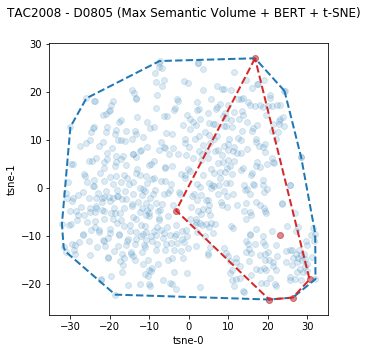

In [16]:
idx = max_semantic_volume_summary(document_embs, 6, distance_to_subspace)

document_pts, summary_pts = project_tsne(document_embs, document_embs[idx])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + BERT + t-SNE)')
ax1 = fig.add_subplot(1,1,1)
plot('tsne', ax1, document_pts, summary_pts, plot_hull=True)

# Plotting SVD

In [17]:
### Load
tac = load_data(DATASET, encoded=False)

### Extract
topic = tac[TOPIC]
documents, summaries, indices, pyr_scores = extract(topic)

### Get indices of sorted pyramid socres
m = np.argsort(-pyr_scores) # Holds sorted indices of the pyramid scores

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

### Count bigrams
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X = vectorizer.fit_transform(documents)

# If bigram b is present in s_i,
# we let s_i,b be the number of documents
# in the corpus that contain bigram b, and
# zero otherwise.
nd = X.sum(axis=0)
X = X.multiply(nd)

### Decompose
svd = TruncatedSVD(n_components=600, random_state=42)
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=600, n_iter=5,
             random_state=42, tol=0.0)

In [19]:
document_embs = svd.transform(vectorizer.transform(documents).multiply(nd))
summary_embs = svd.transform(vectorizer.transform(summaries).multiply(nd))

## System Summaries

### PCA

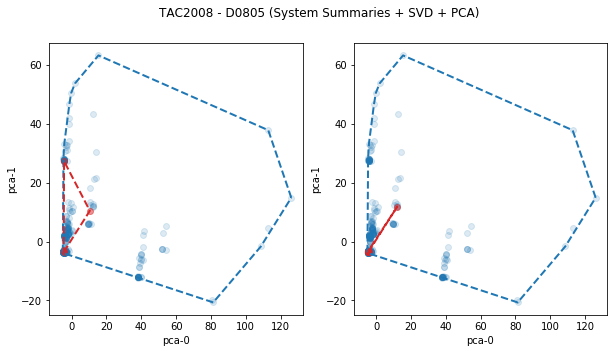

In [20]:
document_pts, summary_pts = project_pca(document_embs, summary_embs)

fig = plt.figure(figsize=(10,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (System Summaries + SVD + PCA)')
ax1 = fig.add_subplot(1,2,1)
plot('pca', ax1, document_pts, summary_pts[indices[m[0],0]:indices[m[0],1]], plot_hull=True)
ax2 = fig.add_subplot(1,2,2)
plot('pca', ax2, document_pts, summary_pts[indices[m[1],0]:indices[m[1],1]], plot_hull=True)

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 897 samples in 0.015s...
[t-SNE] Computed neighbors for 897 samples in 0.591s...
[t-SNE] Computed conditional probabilities for sample 897 / 897
[t-SNE] Mean sigma: 2.613622
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.526413
[t-SNE] KL divergence after 3000 iterations: 0.800271


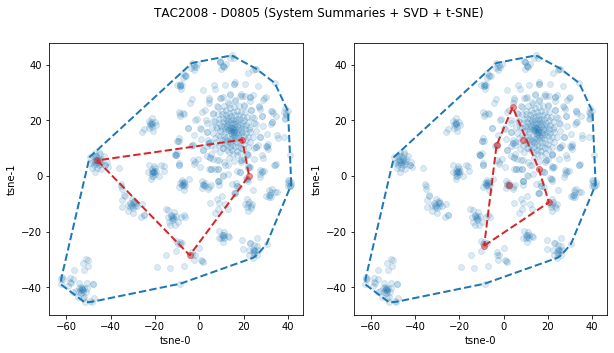

In [21]:
document_pts, summary_pts = project_tsne(document_embs, summary_embs)

fig = plt.figure(figsize=(10,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (System Summaries + SVD + t-SNE)')
ax1 = fig.add_subplot(1,2,1)
plot('tsne', ax1, document_pts, summary_pts[indices[m[0],0]:indices[m[0],1]], plot_hull=True)
ax2 = fig.add_subplot(1,2,2)
plot('tsne', ax2, document_pts, summary_pts[indices[m[1],0]:indices[m[1],1]], plot_hull=True)

## Extractive Summarization by Maximizing Semantic Volume

###  PCA

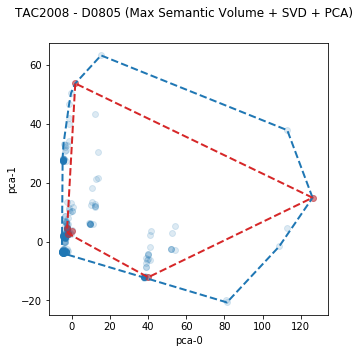

In [22]:
idx = max_semantic_volume_summary(document_embs, 6, distance_to_subspace)

document_pts, summary_pts = project_pca(document_embs, document_embs[idx])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + SVD + PCA)')
ax1 = fig.add_subplot(1,1,1)
plot('pca', ax1, document_pts, summary_pts, plot_hull=True)

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 627 samples in 0.015s...
[t-SNE] Computed neighbors for 627 samples in 0.501s...
[t-SNE] Computed conditional probabilities for sample 627 / 627
[t-SNE] Mean sigma: 3.432336
[t-SNE] KL divergence after 250 iterations with early exaggeration: 93.931671
[t-SNE] KL divergence after 3000 iterations: 0.939446


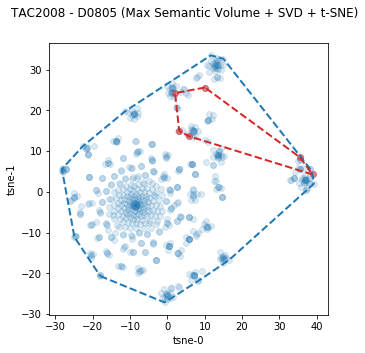

In [23]:
idx = max_semantic_volume_summary(document_embs, 6, distance_to_subspace)

document_pts, summary_pts = project_tsne(document_embs, document_embs[idx])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + SVD + t-SNE)')
ax1 = fig.add_subplot(1,1,1)
plot('tsne', ax1, document_pts, summary_pts, plot_hull=True)

# Interactive plot BERT

In [24]:
### Load
tac = load_data(DATASET, encoded=True)

### Extract
topic = tac[TOPIC]
document_embs, summary_embs, indices, pyr_scores = extract(topic)

### Get indices of sorted pyramid socres
m = np.argsort(-pyr_scores) # Holds sorted indices of the pyramid scores

### PCA

In [25]:
document_pts, summary_pts = project_pca(document_embs, summary_embs)

def make_df(pts, label):
    df = pd.DataFrame(pts, columns=['pca-0','pca-1'])
    df['label'] = label
    return df

df = pd.concat([make_df(document_pts, 'doc')] + \
               [make_df(summary_pts[indices[m[i],0]:indices[m[i],1]], f'sum-{i+1}') for i in range(len(m))], ignore_index=True)

In [26]:
@interact
def scatter_plot(label=df.label.unique()[1:]):
    df[df.label.isin(('doc',label))].iplot(kind='scatter',
                                           title=DATASET + ' - ' + TOPIC,
                                           x='pca-0',y='pca-1',
                                           mode='markers',
                                           categories='label',
                                           theme='solar',
                                           colorscale='set1')

interactive(children=(Dropdown(description='label', options=('sum-1', 'sum-2', 'sum-3', 'sum-4', 'sum-5', 'sum…